In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from jinja2 import Template
from math import sqrt, pi
from scipy.optimize import brentq
import glob, json
import os
import string
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/vbr805/Dropbox/lnps_manuscript/SI-LNPs/data/lnp_empty_310


### activity coefficients of salt ions

Text(0.5, 0, 'Molality  /  mol kg$^{-1}$')

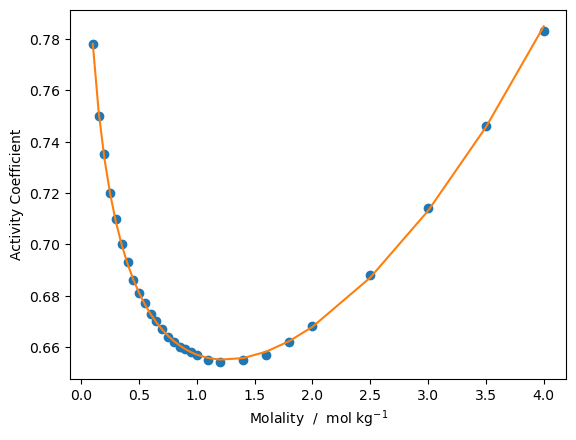

In [8]:
def d_AH(m,salt='NaCl'):
    # density of alkali halides NaCl, NaI, KCl
    # expression from Laliberté et al. DOI: 10.1021/je0498659
    wt = m*df_props[salt]['mw'] # g solute / kg solvent
    wtFrac = wt / (wt + 1000) # weight fraction
    T = 25
    c0, c1, c2, c3, c4 = df_props[salt]['d']['const']
    A = (wtFrac+c2+c3*T)/(c0*wtFrac+c1)/np.exp(1e-6*(T+c4)**2)
    return 1. / ( A*wtFrac + (1-wtFrac) / d_hoh(T) )/1000

def d_hoh(T):
    # density of water Laliberté et al. DOI: 10.1021/je0498659
    nom = (((((-2.8054253*1e-10*T+1.0556302*1e-7)*T-4.6170461*1e-5)*T-0.0079870401)*T+16.945176)*T+999.83952)
    den = 1+0.01687985*T
    return nom/den

def M2m(M,salt='NaCl'): 
    mw = df_props[salt]['mw']
    return brentq(lambda x : x - M/(df_props[salt]['d']['func'](x,salt) - M*mw/1000), 0, 100) 

def m2M(m,salt='NaCl'):
    mw = df_props[salt]['mw']
    return m/(1+m*mw/1000)*df_props[salt]['d']['func'](m,salt)

#MOLALITY
m_nacl = np.array([.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1.0,1.1,1.2,1.4,1.6,1.8,2.0,2.5,3.0,3.5,4.0])

#ACTIVITY COEFF
g_nacl = np.array([.778,.750,.735,.720,.710,.700,.693,.686,.681,.677,.673,.670,.667,.664,.662,.660,.659,.658,.657,.655,.654,.655,.657,.662,.668,.688,.714,.746,.783])

# properties of the salt
df_props = pd.DataFrame({'NaCl':{'mw':58.40,'ActCoef':{'g':g_nacl,'m':m_nacl},'M2m':M2m,
                            'd':{'func':d_AH,'const':[-0.00433,0.06471,1.01660,0.014624,3315.6]}}})

# function to obtain activity coefficients as a function of salt molality
def g_func(m, b1=1.4369, b2=0.0054, b3=0.0495, b4=0.0092):
    return np.exp( -1.18*np.sqrt(m)/(1+b1*np.sqrt(m)) - np.log(1-b2*m) + b3*m + b4*m**2 )

plt.plot(m_nacl,g_nacl, lw=0, marker='o')
plt.plot(m_nacl,g_func(m_nacl))
plt.ylabel('Activity Coefficient')
plt.xlabel('Molality  /  mol kg$^{-1}$')

### pH-dependent activities of salt ions in McIlvain buffer

In [9]:
cation = pd.Series({3:158.2, 4:165.4, 5:170.6, 5.8:174.18, 6.6:179.2, 7.4:186.4, 8:189})
anion = pd.Series({3:157.94, 4:161.47, 5:160.64, 5.8:160.56, 6.6:157.97, 7.4:152.74, 8:150.83})
dianion = pd.Series({3:0.19, 4:1.92, 5:3.54, 5.8:2.82, 6.6:6.79, 7.4:15.44, 8:18.61})
trianion = pd.Series({3:7.6e-5, 4:0.04, 5:0.96, 5.8:2.66, 6.6:2.52, 7.4:0.9, 8:0.28})
pHsalt = pd.DataFrame({'cation':cation, 'anion':anion, 'dianion':dianion, 'trianion':trianion})*1e-3
# Convert molarity of cations and anions to activity using NaCl activity coefficients
pHsalt['cation'] = pHsalt['cation'].apply(lambda x : g_func(M2m(x))*x)
pHsalt['anion'] = pHsalt['anion'].apply(lambda x : g_func(M2m(x))*x)
pHsalt

,cation,anion,dianion,trianion
3.0,0.118348,0.118170,0.00019,7.600000e-08
4.0,0.123260,0.120581,0.00192,4.000000e-05
5.0,0.126796,0.120015,0.00354,9.600000e-04
5.8,0.129225,0.119960,0.00282,2.660000e-03
6.6,0.132623,0.118190,0.00679,2.520000e-03
7.4,0.137483,0.114609,0.01544,9.000000e-04
8.0,0.139234,0.113298,0.01861,2.800000e-04


### lipid models with different CPPs

In [ ]:
df_m = pd.DataFrame()

hd_range = np.arange(1.8,2.51,.05)
t1_range = np.arange(3,4,.05)
t2_range = np.arange(4.1,4.36,.05)

cnt = 0
for hd in hd_range:
    for t1 in t1_range:
        for t2 in t2_range:
            rmax = 2.5*(hd+t2)+3*t1
            l = hd+2*t1+t2
            a = np.pi*hd**2
            v = 1/3 * np.pi * l * (hd**2 + hd * t2 + t2**2)
            cpp = v/l/a
            volume = 4/3*np.pi*(hd**3+t1**3+t2**3)
            df_m.loc[cnt,'volume'] = volume
            df_m.loc[cnt,'v'] = v
            df_m.loc[cnt,'l'] = round(l,1)
            df_m.loc[cnt,'HD'] = hd
            df_m.loc[cnt,'T1'] = t1
            df_m.loc[cnt,'T2'] = t2
            df_m.loc[cnt,'CPP'] = round(cpp,2)
            cnt += 1
            
models = df_m.query('abs(l-13.2)<0.1 and abs(volume-540)<10 and CPP > 1 and CPP <4'
          ).sort_values('CPP')[
    ['HD','T1','T2','CPP']].set_index('CPP').T

models = models[[1.86,2.03,2.06,2.22,2.26,2.54,2.80,2.93,3.03,3.09]]
models = models.loc[:,~models.columns.duplicated()]
','.join([f'{m:g}' for m in models.columns])

In [ ]:
models

### Faunus simulation input for empty LNPs

In [ ]:
template_p = Template("""comment: "3-bead Cooke lipid model. For more information: doi:10/chqzjk"
temperature: {{T}}
random: {seed: hardware}
geometry: {type: hexagonal, length: {{L}}, radius: {{R}}}
mcloop: {macro: 10, micro: {{micro}}}

atomlist:
    - HD:  {sigma: {{RHD*2}}, eps: {{eps}}, dp: 2}
    - HHD: {sigma: {{RHD*2}}, eps: {{eps}}, dp: 2, q: 1}
    - T1:  {sigma: {{RT1*2}}, eps: {{eps}}, dp: 2}
    - T2:  {sigma: {{RT2*2}}, eps: {{eps}}, dp: 2, alphax: -18}
    - NA:  {sigma: 4.6, eps: 0.01, dp: 10, q: 1}
    - CL:  {sigma: 4.6, eps: 0.01, dp: 10, q: -1}
    - H:   {pactivity: {{pH}}, eps: 0.01, implicit: True}

moleculelist:
    - Na: {atoms: [NA], atomic: True, activity: {{pHsalt.loc[pH,'cation']}}}
    - Cl: {atoms: [CL], atomic: True, activity: {{pHsalt.loc[pH,'anion']}}}
    - lipid:
        activity: {{activity}}
        structure:
            - HD: [0,0,0]
            - T1: [0,0,{{RHD+RT1}}]
            - T2: [0,0,{{RHD+2*RT1+RT2}}]
        bondlist:
            - fene: {index: [0,1], k: 1.2, rmax: {{1.5*(RHD+RT1)}}}
            - fene: {index: [1,2], k: 1.2, rmax: {{1.5*(RT1+RT2)}}}
            - harmonic: {index: [0,2], k: 0.4, req: {{2.5*RHD+3*RT1+2.5*RT2}}}
        keeppos: True
            
insertmolecules:
    - Na: {N: 400, inactive: True}
    - Cl: {N: 400, inactive: True}
    - lipid: {N: 400, inactive: True}
    
energy:
    - bonded: {}
    - nonbonded_splined:
        default:
            - wca:
                mixing: LB
            - custom:
                cutoff: 1000
                function: lB * q1 * q2 * ( 1.0 / r - 1.0 / Rc )
                constants:
                    lB: {{lB}}
            - polar: {epsr: {{epsw}}}
        T1 T1:
            - wca:
                mixing: LB
            - cos2: {rc: {{1.122462*2*RT1}}, eps: {{eps}}, wc: {{wc*2*RT1}}}
        T1 T2:
            - wca:
                mixing: LB
            - cos2: {rc: {{1.122462*(RT1+RT2)}}, eps: {{eps}}, wc: {{wc*(RT1+RT2)}}}
        T2 T2:
            - wca:
                mixing: LB
            - cos2: {rc: {{1.122462*2*RT2}}, eps: {{eps}}, wc: {{wc*2*RT2}}}

reactionlist:
    - "HHD = HD + Na + H": {pK: {{pKa}}}
    - "HHD + Cl = HD + H": {pK: {{pKa}}}
    - "= Na + Cl": {}
    - "= lipid": {neutral: True}

moves:
    - rcmc: {repeat: 20}
    - moltransrot: {molecule: lipid, dp: 0.2, dprot: 0.5, repeat: 200}
    - transrot: {molecule: lipid, repeat: {{repeat}}}
    - transrot: {molecule: Cl, repeat: N}
    - transrot: {molecule: Na, repeat: {{repeat}}}
    - volume: {dV: 0.05, method: isochoric, repeat: 1}
    
analysis:
    - savestate: {file: state.json}
    - savestate: {file: confout.pqr}
    - savestate: {file: confout.gro}
    - xtcfile: {file: traj.xtc, nstep: 1e4}
    - systemenergy: {file: energy.dat, nstep: 1e4}
    - savestate: {file: cuboid.pqr, convert_hexagon: True, nstep: 1e3}
    - qrfile: {file: qrtraj.dat, nstep: 1e4}
    - reactioncoordinate: {file: charge.dat, nstep: 1e3, type: system, property: Q}
    - reactioncoordinate: {file: order.dat, nstep: 1e3, type: system, property: OrderParam, index: 2}
    - reactioncoordinate: {file: NNa.dat, nstep: 1e3, type: molecule, property: N, index: 0}
    - reactioncoordinate: {file: NCl.dat, nstep: 1e3, type: molecule, property: N, index: 1}
    - reactioncoordinate: {file: Nlipids.dat, nstep: 1e3, type: atom, property: N, index: 2}
    - reactioncoordinate: {file: radius.dat, nstep: 1e3, type: system, property: radius}
    - reactioncoordinate: {file: Lz.dat, nstep: 1e3, type: system, property: Lz}
    - reactioncoordinate: {file: NHHD.dat, nstep: 1e3, type: atom, property: N, index: 1}
    - reactioncoordinate: {file: RCl.dat, nstep: 1e3, type: molecule, property: Rinner, indexes: [2,3,5,5], dir: [1,1,0]}
    - reactioncoordinate: {file: Rcyl.dat, nstep: 1e3, type: molecule, property: Rinner, indexes: [2,3,0,1], dir: [1,1,0]}
    - atomprofile: {file: distCL.dat, nstep: 1e3, atoms: [CL], dir: [1,1,0], atomcom: T1, dr: 0.2}
""")

In [ ]:
submit = Template("""#!/bin/bash
#requesting the number of cores needed on exclusive nodes
#SBATCH -N 1
#SBATCH --ntasks-per-node=1
#SBATCH -A lu2023-2-83
#
# job time, change for what your job requires
#SBATCH -t 48:0:0
#
# job name
#SBATCH -J {{dirname}}
#
# filenames stdout and stderr
#SBATCH -o out
#SBATCH -e err

source /home/gtesei00/.bashrc
module load GCCcore/12.3.0
module load CMake/3.26.3
module load GCC/12.3.0
conda activate faunus

/home/gtesei00/Jun22/faunus/faunus --input inp.json --output outp.json --state state.json -v0
""")

### generate scripts and run simulations

In [ ]:
T = 310 # K
R = 8.3145 # J/K/mol
eps = R*T*1e-3 # kJ/mol
print("eps:",eps,"kJ/mol")
fepsw = lambda T : 5321/T+233.76-0.9297*T+0.1417*1e-2*T*T-0.8292*1e-6*T**3
epsw = fepsw(T)
lB = 1.60217662**2/(4*np.pi*8.8541878*epsw*2/3*1.38064852*T)*1e7
print(lB,eps,epsw)

In [ ]:
%cd $workdir
faunus_path = '../../faunus'
Nnuc = 72
zcoords = np.repeat(np.linspace(0, 28*np.pi, Nnuc),2)
L = zcoords.max(); V = 320000; R = np.sqrt( V / L / 2 / np.sqrt(3) )
xcoords = np.cos(np.linspace(0, 28*np.pi, Nnuc)/2.7)
ycoords = np.sin(np.linspace(0, 28*np.pi, Nnuc)/2.7)
xcoords = np.vstack([xcoords*R/3,xcoords*(R/3-4)]).ravel('F')
ycoords = np.vstack([ycoords*R/3,ycoords*(R/3-4)]).ravel('F')
print(L,R)
pKa = 8.46
for m in [1.86,3.09][:1]:
    for pH in pHsalt.index.values[:]:
        if not os.path.isdir(dirname.format(m,pKa,pH)):
            !mkdir {dirname.format(m,pKa,pH)}
        !cp {dirname_rna.format(m,pKa,pH)}/state.json {dirname.format(m,pKa,pH)}
        %cd {dirname.format(m,pKa,pH)}
        aL = 1e-3/(1+10**(pKa-pH))
        with open('inp.yml', 'w') as input_file:
            input_file.write(template_p.render(T=T, wc=1.8, L=L, R=R, micro=2e5,
                        RHD=models.loc['HD',m], RT1=models.loc['T1',m],
                        RT2=models.loc['T2',m], repeat=10, pKa=pKa,
                        pHsalt=pHsalt, pH=pH, epsw=epsw, lB=lB, eps=eps,
                        activity=aL))
        !{faunus_path}/scripts/yason.py inp.yml > inp.json
        with open('submit.sh', 'w') as submit_file:
            temp = submit.render(dirname=dirname.format(m,pKa,pH,aL))
            submit_file.write(temp)
        #!nohup {faunus_path}/faunus --input inp.json --output outp.json --state state.json &
        #!sbatch submit.sh
        %cd ..